In [70]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
@author: omayr
@description: POC: Time Series Analysis of CampusKlubi Temperature Data
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display    

def read_file():
    
    data = pd.read_csv("data/sample/room_temperature_1710876.csv")
    data['utc_org_rec_time'] = pd.to_datetime(data['utc_org_rec_time'])
    data['utc_org_rec_time'] = pd.DatetimeIndex(data['utc_org_rec_time'])
    data.columns = ['time','RT']
    data = data.set_index(['time'])
    return data['RT']

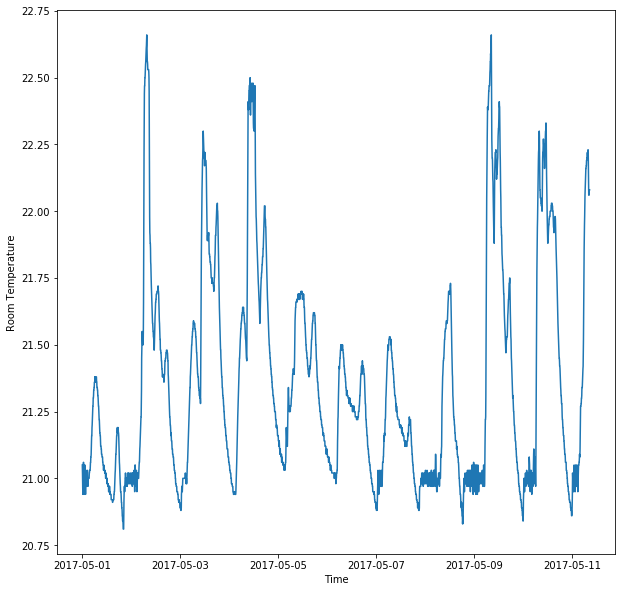

In [71]:
def ts_analysis():
    
    ts = read_file()
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.plot(ts[2016:])
    plt.ylabel('Room Temperature')
    plt.xlabel('Time')
    plt.show()
    
ts_analysis()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


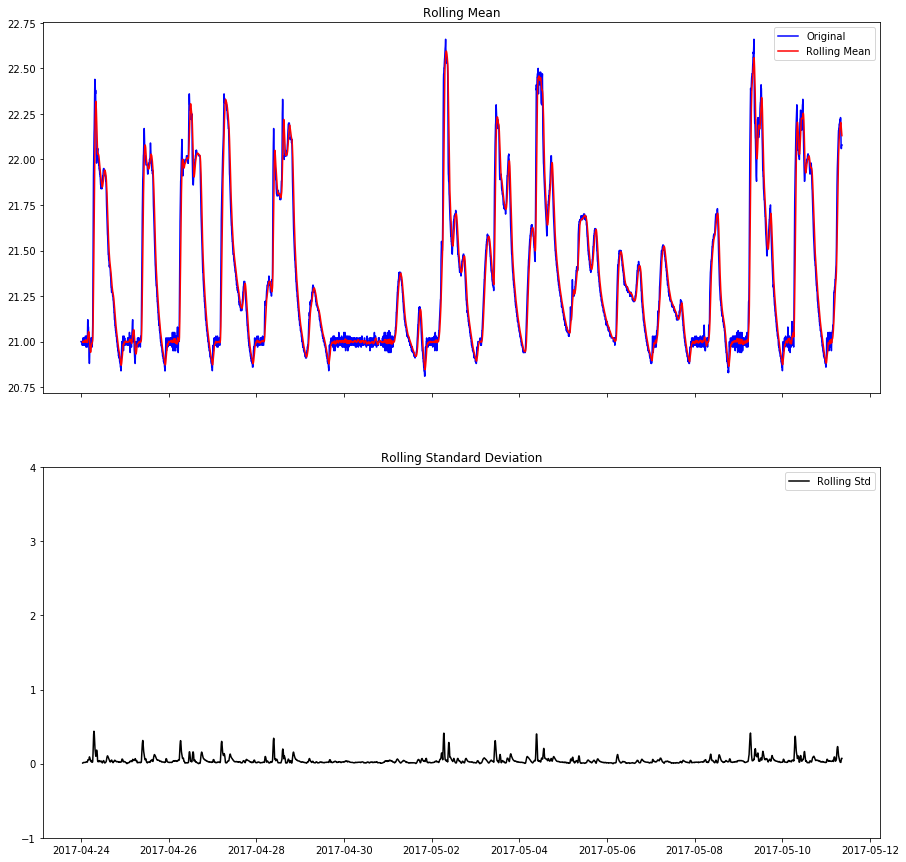

'Results of Dickey-Fuller Test:'

Test Statistic                -6.385937e+00
p-value                        2.164265e-08
#Lags Used                     1.300000e+01
Number of Observations Used    4.986000e+03
Critical Value (5%)           -2.862120e+00
Critical Value (1%)           -3.431662e+00
Critical Value (10%)          -2.567079e+00
dtype: float64

In [83]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(ts):
    
    
    rolling_mean = pd.rolling_mean(ts, window=12)
    rolling_std = pd.rolling_std(ts, window=12)
    
    #Plot rolling statistics:
    f, axarr = plt.subplots(2, figsize=(15,15), sharex=True)
    axarr[0].plot(ts, color='blue',label='Original')
    axarr[0].plot(rolling_mean, color='red', label='Rolling Mean')
    axarr[0].set_title('Rolling Mean')
    axarr[0].legend(loc='best')
    
    axarr[1].plot(rolling_std, color='black', label = 'Rolling Std')
    axarr[1].set_ylim([-1,4])
    axarr[1].set_title('Rolling Standard Deviation')
    axarr[1].legend(loc='best')
    
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    display('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    display(dfoutput)

ts = read_file()
stationarity_test(ts)



/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if sys.path[0] == '':


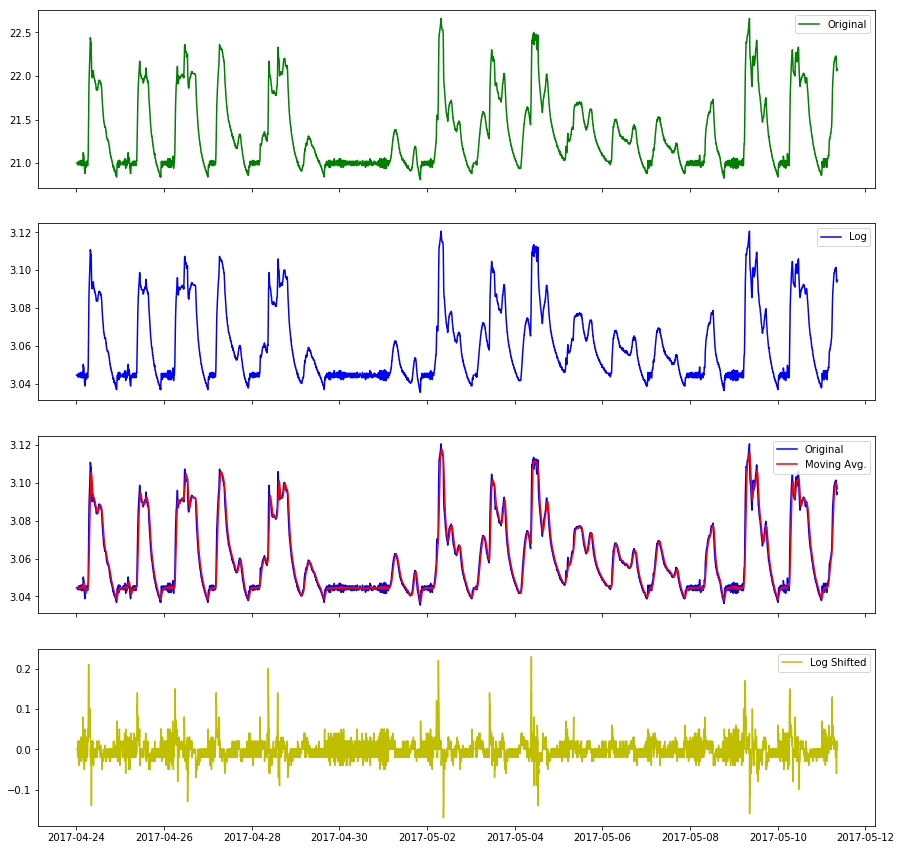

In [113]:
def ts_detrend_deseason():
    
    ts = read_file()
    f, axarr = plt.subplots(4, figsize=(15,15), sharex=True)
    
    ts_log = np.log(ts)
    axarr[0].plot(ts,'g',label="Original")
    axarr[0].legend(loc='best')
    axarr[1].plot(ts_log,'b',label="Log")
    axarr[1].legend(loc='best')
    
    moving_avg = pd.rolling_mean(ts_log,12)
    
    ts_log_moving_avg_diff = ts_log - moving_avg
    ts_log_moving_avg_diff.dropna(inplace=True)
    
    axarr[2].plot(ts_log,'b',label = 'Original')
    axarr[2].plot(moving_avg, 'r', label = 'Moving Avg.')
    axarr[2].legend(loc='best')
    
    ts_diff = ts - ts.shift()
    axarr[3].plot(ts_diff, 'y', label = 'Log Shifted')
    axarr[3].legend(loc='best')
    
    plt.show()
    
    
ts_detrend_deseason()

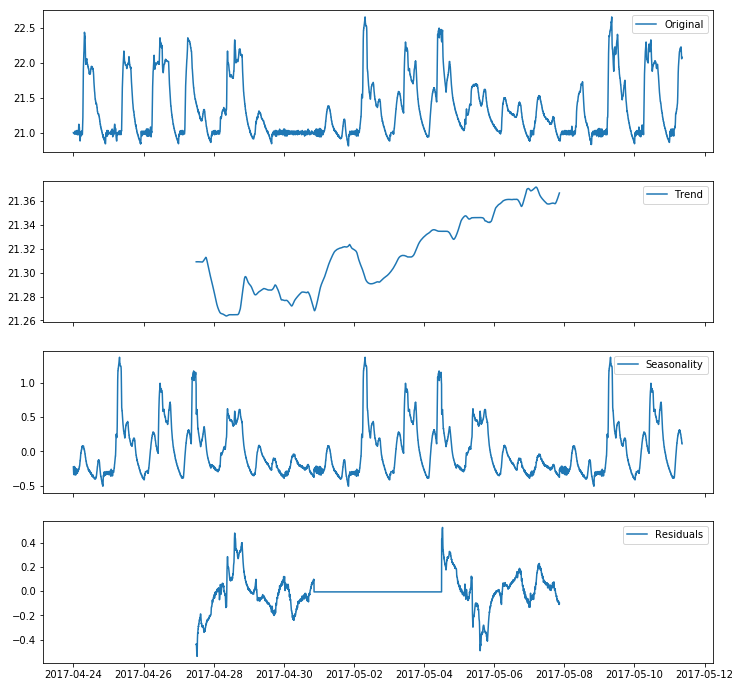

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose

def deseason():
    ts = read_file()

    ts_log = np.log(ts)
    decomposition = seasonal_decompose(ts,freq=2016)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    f, axarr = plt.subplots(4,figsize=(12,12),sharex=True)

    axarr[0].plot(ts, label='Original')
    axarr[0].legend(loc='best')
    axarr[1].plot(trend, label='Trend')
    axarr[1].legend(loc='best')
    axarr[2].plot(seasonal,label='Seasonality')
    axarr[2].legend(loc='best')
    axarr[3].plot(residual, label='Residuals')
    axarr[3].legend(loc='best')
    plt.show()

deseason()

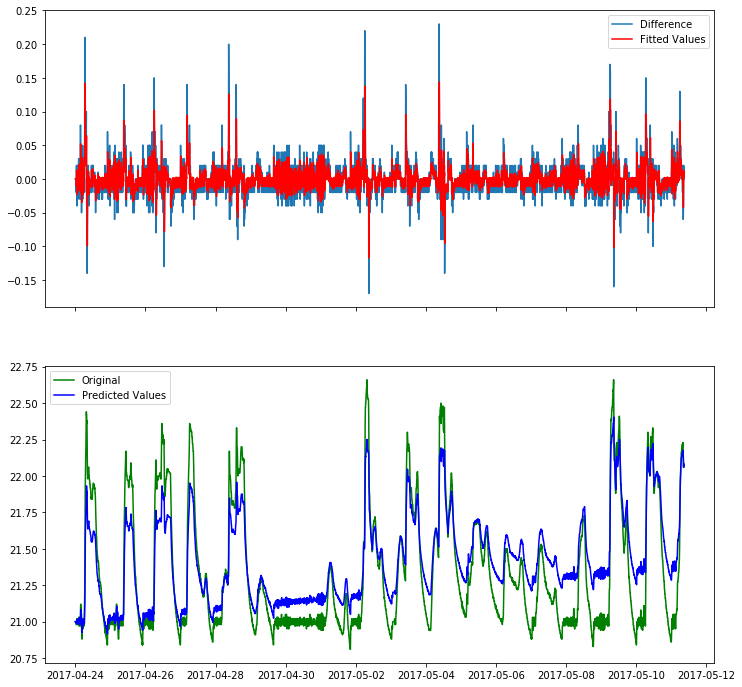

In [131]:
from statsmodels.tsa.arima_model import ARIMA

def prediction():
    ts = read_file()
    ts_diff = ts - ts.shift()
    model = ARIMA(ts, order=(2, 1, 2))  
    results_ARIMA = model.fit(disp=-1)  
    
    predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    predictions_ARIMA = pd.Series(ts.iloc[0], index=ts.index)
    predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum,fill_value=0)
    
    f, axarr = plt.subplots(2,figsize=(12,12), sharex=True)
    axarr[0].plot(ts_diff, label = 'Difference')
    axarr[0].plot(results_ARIMA.fittedvalues, color='red', label = 'Fitted Values')
    axarr[0].legend(loc='best')
    #axarr[].title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_diff)**2))
    axarr[1].plot(ts, 'g', label='Original')
    axarr[1].plot(predictions_ARIMA, 'b', label='Predicted Values' )
    axarr[1].legend(loc='best')
    #plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
    plt.show()

prediction()